In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

## Download data

### Proximity data

In [2]:
schema = 'prox_analysis'
folder = 'proximityanalysis_v2_23_mzaageb_hex'
city = 'Queretaro'
res = 9

query = f"SELECT * FROM {schema}.{folder} WHERE \"city\" = \'{city}\' and \"res\" = \'{res}\' "

hex_prox = aup.gdf_from_query(query)
print(hex_prox.shape)
hex_prox.head(2)

(2766, 69)


,hex_id,res,geometry,max_escuelas,max_preescolar,max_primaria,max_secundaria,max_servicios comunitarios,max_salud,max_guarderías,...,pobmas,p_0a5,p_6a11,p_12a17,p_18a24,p_25a59,p_60ymas,pcon_disc,dens_pob_ha,city
0,894982260d3ffff,9,"POLYGON ((-100.22807 20.66866, -100.22682 20.6...",30.039024,29.911330,25.573928,30.039024,121.378771,87.312482,121.378771,...,22.137665,3.63205,6.007860,5.882644,7.525987,20.859377,2.618004,0.564943,3.821312,Queretaro
1,894983ca513ffff,9,"POLYGON ((-100.41923 20.59888, -100.41799 20.6...",34.408358,14.363832,17.717887,34.408358,32.406565,10.578492,27.337972,...,62.689045,5.26559,12.731618,9.207241,16.440184,64.808566,19.172720,6.444009,10.471443,Queretaro


In [3]:
hex_prox.columns

Index(['hex_id', 'res', 'geometry', 'max_escuelas', 'max_preescolar',
       'max_primaria', 'max_secundaria', 'max_servicios comunitarios',
       'max_salud', 'max_guarderías', 'max_asistencia social', 'max_comercio',
       'max_alimentos', 'max_personal', 'max_farmacias', 'max_hogar',
       'max_complementarios', 'max_entretenimiento', 'max_social',
       'max_actividad física', 'max_cultural', 'escuelas_15min',
       'preescolar_15min', 'primaria_15min', 'secundaria_15min',
       'servicios comunitarios_15min', 'salud_15min', 'guarderías_15min',
       'asistencia social_15min', 'comercio_15min', 'alimentos_15min',
       'personal_15min', 'farmacias_15min', 'hogar_15min',
       'complementarios_15min', 'entretenimiento_15min', 'social_15min',
       'actividad física_15min', 'cultural_15min', 'idx_preescolar',
       'idx_primaria', 'idx_secundaria', 'idx_salud', 'idx_guarderías',
       'idx_asistencia social', 'idx_alimentos', 'idx_personal',
       'idx_farmacias', 'idx_h

#### View specific amenity

In [4]:
hex_prox[['idx_sum']].head(2)

,idx_sum
0,8.132422
1,11.302987


<Axes: >

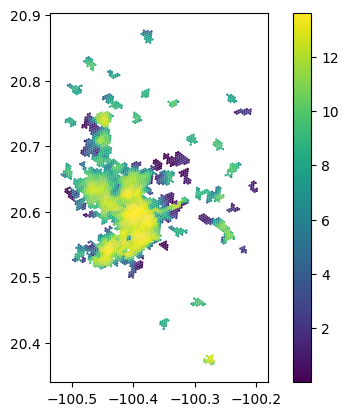

In [5]:
hex_prox.plot('idx_sum', legend=True)

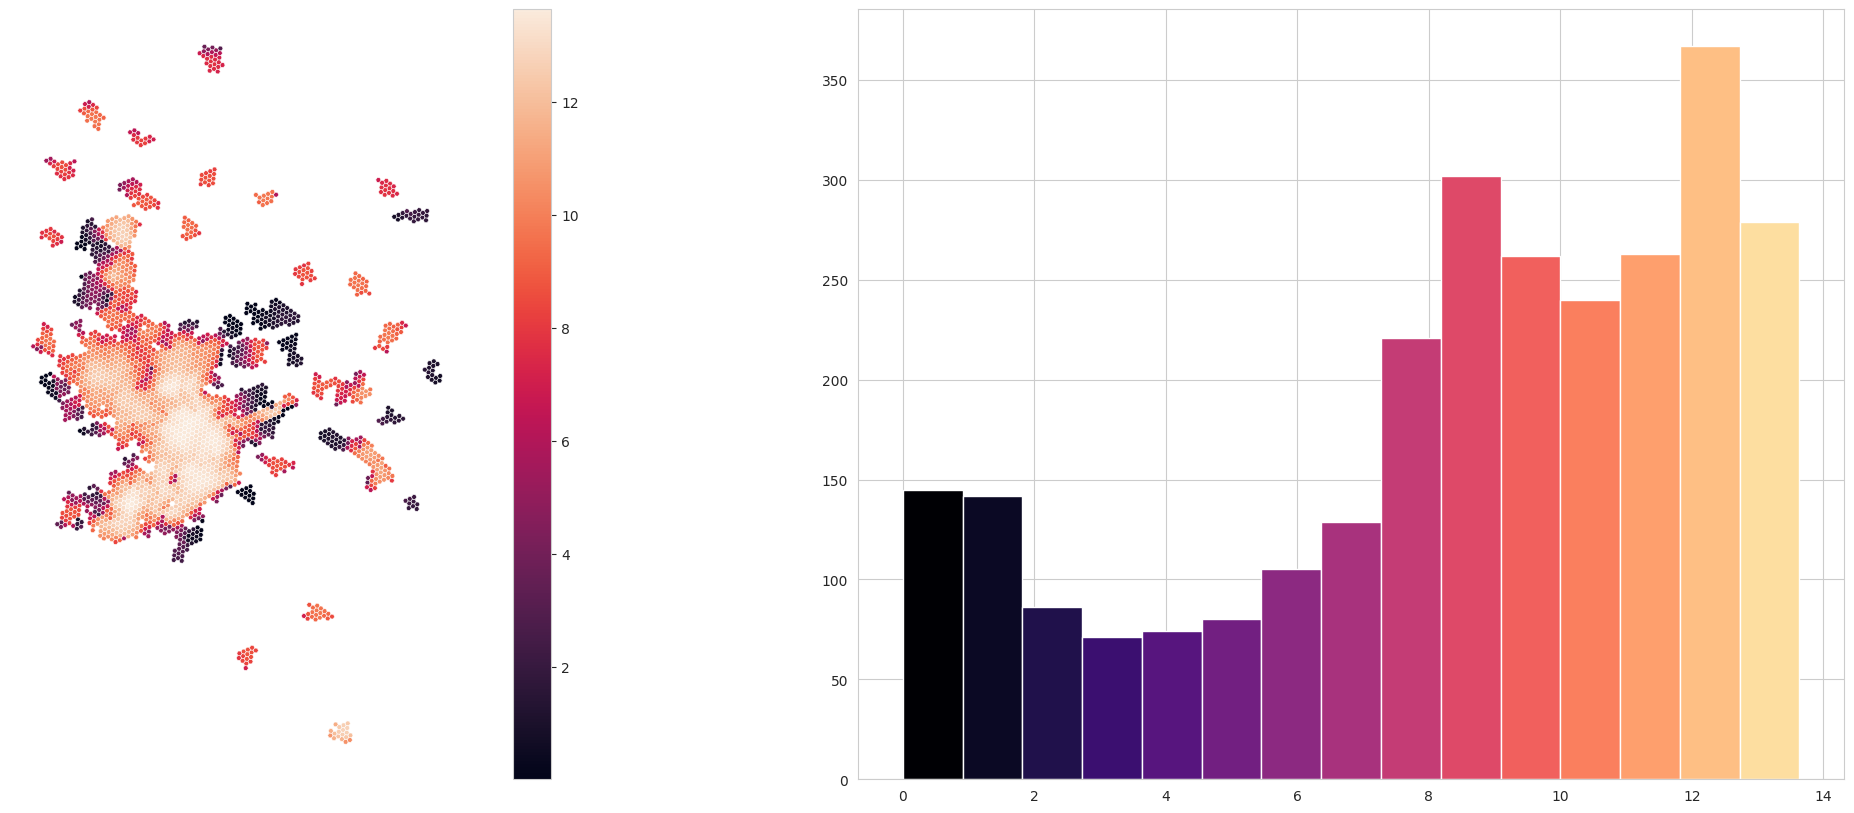

In [6]:
import seaborn as sns 

column_analysis = 'idx_sum'

sns.set_style("whitegrid")

fig, ax = plt.subplots(1,2, figsize=(28,10))
hex_prox.plot(column=column_analysis, linewidth=0.4,
                       legend=True, ax=ax[0]) 
ax[0].set_axis_off()

hex_prox.sort_values(column_analysis,inplace=True)
hex_prox.reset_index(drop=True, inplace=True)
n, bins, patches = ax[1].hist(hex_prox[column_analysis],
                             15, color='green')

cm = plt.cm.magma
 
for i, p in enumerate(patches):
    plt.setp(p, 'facecolor', cm(i/len(n))) # notice the i/25

## Save data

In [7]:
hex_prox.to_file('../../../data/processed/Distrito_QRO/hex_proximity_distrito_qro.geojson')